In [1]:
import pandas as pd
merged_df = pd.read_csv('Merged_DatasetV2.csv')
merged_df.head()

/tmp/ipykernel_25441/2551388421.py:2: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv('Merged_DatasetV2.csv')


,Unnamed: 0,id,type,name,city,state,county,country,lifespan_years,status,services_offered
0,0,f9a1fd95-4c6d-43a6-bb31-4ee8d5a44a8b,Studio,Columbia (CBS) Studio ‘B’,Test Restaurant,New York,NaN,US,NaN,Active,NaN
1,1,42e9fa7c-a981-44f9-943c-bf39a8c6ce8d,Venue,New Theatre Oxford,Victoria House Hotel,England,Oxfordshire,GB,NaN,Active,NaN
2,2,34e7351d-715d-4b20-a5d6-3c0bd717eb1d,Religious building,Santuario della Beata Vergine di Ariadello,Genivolta,NaN,NaN,IT,359.0,Active,NaN
3,3,0ad32768-514b-410f-9d5a-40ebb0c3373c,Studio,ROKU-st,Tenso Jinja,NaN,NaN,JP,NaN,Active,NaN
4,4,0b050655-48da-4be7-b5de-7a3ee7370b9e,Venue,Rätschenmühle,Geislingen an der Steige,NaN,NaN,DE,NaN,Active,NaN


In [2]:
# Drop rows where 'services_offered' is null
merged_df = merged_df.dropna(subset=['services_offered'])

# Drop unnecessary columns
merged_df = merged_df.drop(columns=['Unnamed: 0', 'id', 'name'])

# Display the updated dataframe
merged_df.head()


,type,city,state,county,country,lifespan_years,status,services_offered
15520,Other,Los Jarales,NaN,NaN,VE,NaN,Active,recorded at
15521,Venue,Plasky,Brussels Capital,Bruxelles-Capitale,BE,62.0,Active,recorded at
15522,Other,Dunluce Castle,Northern Ireland,Causeway Coast and Glens,GB,NaN,Active,recorded at
15524,Studio,Saint Johns Eastern Orthodox Church,Tennessee,NaN,US,5.0,Ended,engineered at
15525,Venue,Shimokitazawa Eki,NaN,NaN,JP,34.0,Active,recorded at


In [3]:
# Ensure the column is string type and split by commas (handling spaces)
merged_df['services_offered'] = merged_df['services_offered'].astype(str).str.split(r',\s*')

# Explode the dataframe to have one service per row
merged_df = merged_df.explode('services_offered')

# Trim any leading or trailing spaces (just in case)
merged_df['services_offered'] = merged_df['services_offered'].str.strip()

# Drop any empty values that might have been created
merged_df = merged_df[merged_df['services_offered'].notna() & (merged_df['services_offered'] != '')]

# Reset index after exploding
merged_df = merged_df.reset_index(drop=True)


In [4]:
import re

# Function to remove the last word and underscore
def remove_last_part(text):
    return re.sub(r'_[^_]+$', '', text)  # Removes the last underscore and the word after it

# Apply the function to the column
merged_df['services_offered'] = merged_df['services_offered'].astype(str).apply(remove_last_part)

# Display the cleaned column
print(merged_df['services_offered'].unique())


['recorded at' 'engineered at' 'edited at' 'mixed at' 'video shot at'
 'lyrics written at' 'produced at' 'premiere' 'written at' 'commissioned'
 'composed at' 'arranged at' 'dedication' 'revised at' 'remixed at']


In [5]:
def impute_df(df):
    # Fill non-numeric columns with "Missing"
    cols_to_fill = df.columns.difference(['lifespan_years'])
    df[cols_to_fill] = df[cols_to_fill].fillna("Missing")
    
    # Create missing indicator for 'lifespan_years'
    df['lifespan_years_missing'] = df['lifespan_years'].isnull().astype(int)
    
    # Impute missing values in 'lifespan_years' with the median value
    median_val = df['lifespan_years'].median()
    df['lifespan_years'] = df['lifespan_years'].fillna(median_val)
    
    return df

In [6]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)


train_df = impute_df(train_df)
test_df = impute_df(test_df)

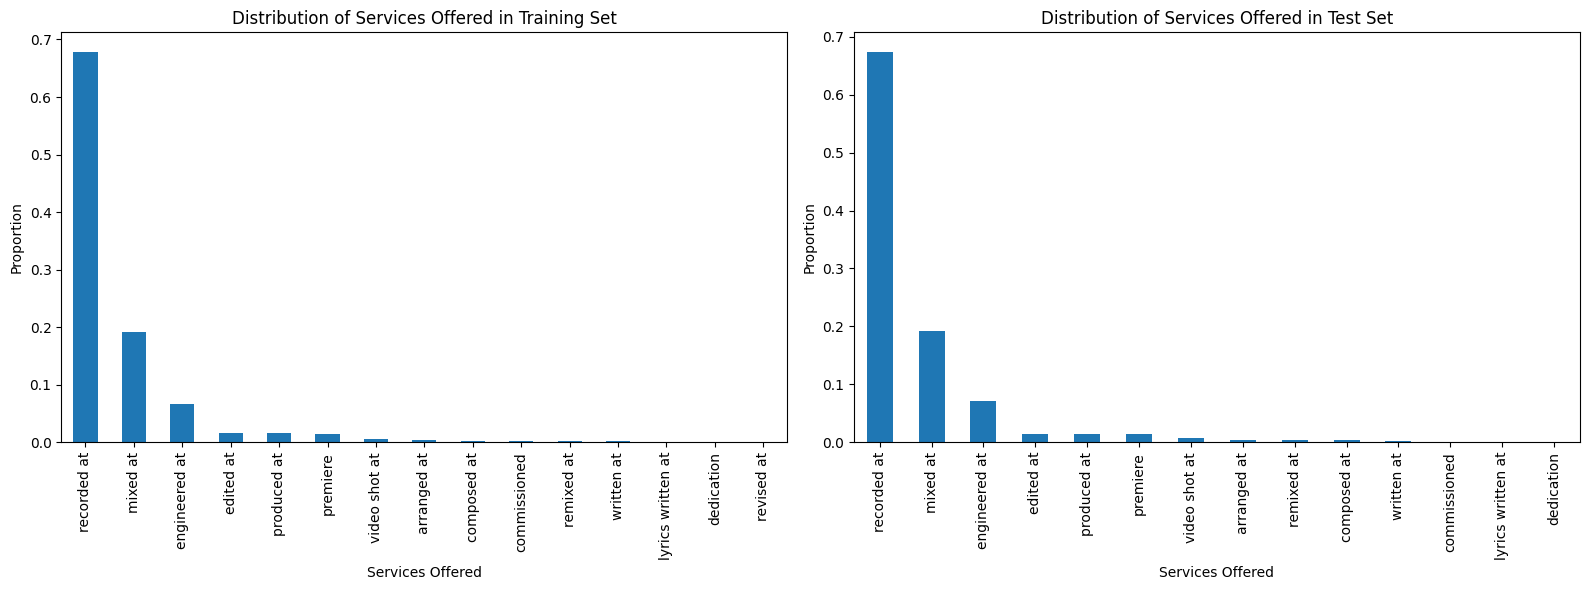

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set chart
train_counts = train_df['services_offered'].value_counts(normalize=True)
train_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title("Distribution of Services Offered in Training Set")
axes[0].set_xlabel("Services Offered")
axes[0].set_ylabel("Proportion")

# Test set chart
test_counts = test_df['services_offered'].value_counts(normalize=True)
test_counts.plot(kind='bar', ax=axes[1])
axes[1].set_title("Distribution of Services Offered in Test Set")
axes[1].set_xlabel("Services Offered")
axes[1].set_ylabel("Proportion")

plt.tight_layout()
plt.show()

In [9]:
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# Assume train_df and test_df are already loaded.

# Transform your training data as before.
X_train = pd.get_dummies(train_df.drop(columns=["services_offered", "lifespan_years"]), drop_first=True)
X_train["lifespan_years"] = train_df["lifespan_years"]
X_train.columns = X_train.columns.astype(str).str.replace(r"[,\[\]<>]", "_", regex=True)

# Similarly, transform the test data.
X_test = pd.get_dummies(test_df.drop(columns=["services_offered", "lifespan_years"]), drop_first=True)
X_test["lifespan_years"] = test_df["lifespan_years"]
X_test.columns = X_test.columns.astype(str).str.replace(r"[,\[\]<>]", "_", regex=True)

# Reindex X_test to have the same columns as X_train, filling missing columns with zeros.
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Encode the target variable.
le = LabelEncoder()
y_train = le.fit_transform(train_df["services_offered"])
y_test = le.fit_transform(test_df["services_offered"])

# Initialize the cross-validation scheme.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List to store macro F1 scores for each fold.
f1_list = []

# Manual cross-validation loop.
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_val_fold = y_train[val_idx]
    
    # Train the model.
    model = xgb.XGBClassifier(random_state=42)
    model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold.
    preds = model.predict(X_val_fold)
    
    # Calculate macro F1 score.
    f1 = f1_score(y_val_fold, preds, average='macro')
    f1_list.append(f1)
    
    print(f"Fold {fold}: Macro F1 Score={f1:.4f}")

# Compute and print overall cross-validation macro F1 score.
print("\nCross-Validation Results:")
print("Macro F1 Score: Mean =", np.mean(f1_list), ", Std =", np.std(f1_list))

# Train on full training set and evaluate on the test set.
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Optionally, convert predictions back to original labels.
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)


/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1: Macro F1 Score=0.0807
Fold 2: Macro F1 Score=0.0957
Fold 3: Macro F1 Score=0.0949
Fold 4: Macro F1 Score=0.0765
Fold 5: Macro F1 Score=0.0890

Cross-Validation Results:
Macro F1 Score: Mean = 0.08734789025941532 , Std = 0.007642725334229131


In [10]:
from sklearn.metrics import classification_report

# Print the classification report across all target classes
print(classification_report(y_test_labels, y_pred_labels))

                   precision    recall  f1-score   support

      arranged at       0.00      0.00      0.00        15
     commissioned       0.00      0.00      0.00         3
      composed at       0.00      0.00      0.00        10
       dedication       0.00      0.00      0.00         1
        edited at       0.12      0.02      0.03        51
    engineered at       0.32      0.03      0.06       243
lyrics written at       0.00      0.00      0.00         2
         mixed at       0.37      0.11      0.17       659
         premiere       0.00      0.00      0.00        46
      produced at       0.00      0.00      0.00        48
      recorded at       0.70      0.97      0.81      2321
       remixed at       0.00      0.00      0.00        11
    video shot at       0.00      0.00      0.00        23
       written at       0.00      0.00      0.00         9

         accuracy                           0.68      3442
        macro avg       0.11      0.08      0.08      

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


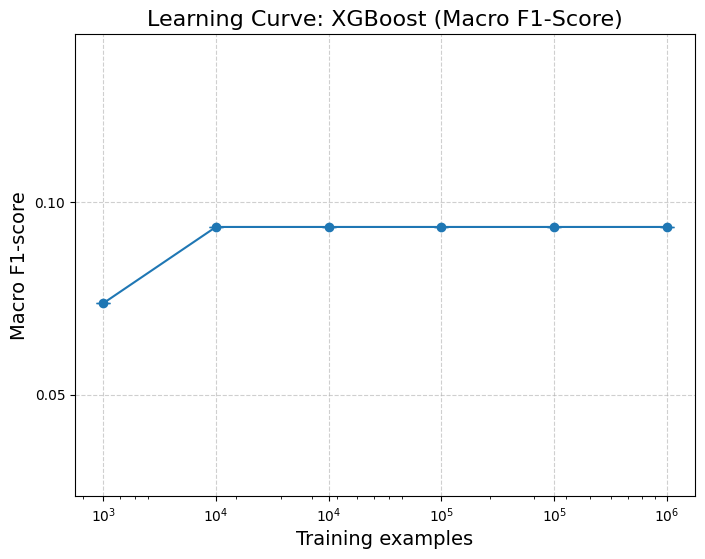

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

# Define training sizes - 10^2, 10^3, etc.
train_sizes = np.logspace(2, 6, 10, dtype=int)

# Encode target labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
unique_classes = np.unique(y_train_encoded) 

f1_scores = []
std_devs = []

# Stratified sampling necessary due to class imbalance
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_size in train_sizes:
    f1_list = []
    
    for train_idx, _ in sss.split(X_train, y_train_encoded):
        X_train_subset = X_train.iloc[train_idx[:train_size]]
        y_train_subset = y_train_encoded[train_idx[:train_size]]

        # Ensure all classes are represented, skip if training subset is missing classes
        missing_classes = np.setdiff1d(unique_classes, np.unique(y_train_subset))
        if missing_classes.size > 0:
            continue  

        # Train XGBoost model
        model = xgb.XGBClassifier(random_state=42, objective='multi:softmax', num_class=len(unique_classes))
        model.fit(X_train_subset, y_train_subset)

        # Predict X_test
        y_pred = model.predict(X_test)

        # Compute macro F1-score
        f1_list.append(f1_score(y_test, y_pred, average='macro'))
    # Only add results if we successfully trained
    if f1_list:
        f1_scores.append(np.mean(f1_list))
        std_devs.append(np.std(f1_list))
    else:
        f1_scores.append(None)
        std_devs.append(None)

# Convert to NumPy arrays for easy filtering
f1_scores = np.array(f1_scores, dtype=np.float64)
std_devs = np.array(std_devs, dtype=np.float64)

# Remove failed training sizes
valid_indices = ~np.isnan(f1_scores)

# Filter valid points
train_sizes = train_sizes[valid_indices]
f1_scores = f1_scores[valid_indices]
std_devs = std_devs[valid_indices]

# Plot the learning curve analysis
plt.figure(figsize=(8, 6))
plt.errorbar(train_sizes, f1_scores, yerr=std_devs, fmt='o-', capsize=5)

plt.xscale("log")
plt.xticks(train_sizes, labels=[f"$10^{int(np.log10(t))}$" for t in train_sizes])
plt.yticks(np.arange(np.floor(min(f1_scores) * 10) / 10, np.ceil(max(f1_scores) * 10) / 10 + 0.01, 0.05))  
plt.ylim(min(f1_scores) - 0.05, max(f1_scores) + 0.05)  

plt.xlabel("Training examples", fontsize=14)
plt.ylabel("Macro F1-score", fontsize=14)
plt.title("Learning Curve: XGBoost (Macro F1-Score)", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()